# Minimum Feedback Vertex Set on Directed Graphs

This notebook contains an annotated implementation of several algorithms for the **Minimum Feedback Vertex Set (MFVS)** problem ondirected graphs.

**Algorithms included:**
1. Naive Exact FVS
2. Greedy Frequency
3. Greedy Degree‑Product
5. Wang–Lloyd–Soffa
6. Small‑k Iterative Compression

**Notes:**
* The notebook contains function that loads a directed graph from a delimited edge-list file and returns it as a NetworkX DiGraph, and function that generates random directed graphs of varying sizes and densities, visualizes them, and applies several heuristics and exact methods to analyze or approximate solutions for each graph.

## Imports & Directed Utilities

In [1]:
import itertools, time, csv
from typing import List, Set, Dict, Iterable, Tuple
import networkx as nx
import matplotlib.pyplot as plt

def is_acyclic(G: nx.DiGraph) -> bool:
    """Return True if G is a DAG (no directed cycles)."""
    if not G.is_directed():
        raise TypeError('Expected nx.DiGraph for DFVS utilities.')
    return nx.is_directed_acyclic_graph(G)

def cycle_basis(G: nx.DiGraph) -> List[List]:
    """Directed analog: list of simple directed cycles (may be many)."""
    if not G.is_directed():
        raise TypeError('Expected nx.DiGraph for DFVS utilities.')
    return list(nx.simple_cycles(G))

def clean_graph(G: nx.DiGraph) -> nx.DiGraph:
    """Iteratively remove sources (in=0) and sinks (out=0)."""
    if not G.is_directed():
        raise TypeError('Expected nx.DiGraph for DFVS utilities.')
    H = G.copy(); changed = True
    while changed:
        changed = False
        for v in list(H.nodes()):
            if H.in_degree(v) == 0 or H.out_degree(v) == 0:
                H.remove_node(v); changed = True
    return H

def validate_dfvs(G: nx.DiGraph, F: Iterable) -> bool:
    H = G.copy(); H.remove_nodes_from(list(F))
    return nx.is_directed_acyclic_graph(H)

# Visualization helpers
def draw_digraph(G: nx.DiGraph, title: str=''):
    pos = nx.spring_layout(G, seed=7)
    nx.draw(G, pos, with_labels=True, arrows=True)
    plt.title(title); plt.show()

def highlight_dfvs(G: nx.DiGraph, F: Set, title: str=''):
    pos = nx.spring_layout(G, seed=7)
    colors = ['C3' if v in F else 'C0' for v in G.nodes()]
    nx.draw(G, pos, with_labels=True, arrows=True, node_color=colors)
    plt.title(title); plt.show()

def visualize_solution(G: nx.DiGraph, F: Set, label: str, runtime: float):
    print(f"{label}: |F|={len(F)}, time={runtime:.4f}s, valid={validate_dfvs(G,F)}")
    highlight_dfvs(G, F, title=f"{label}: highlighted DFVS")
    H = G.copy(); H.remove_nodes_from(F)
    draw_digraph(H, title=f"{label}: DAG after removing DFVS")


## Naive Exact FVS (small graphs only)

In [2]:
def naive_dfvs(G: nx.DiGraph, time_limit: float | None = None) -> Set:
    """Exhaustive search over vertex subsets; only for tiny graphs."""
    start = time.time()
    if is_acyclic(G):
        return set()
    V = list(G.nodes())
    best = set(V)
    for r in range(1, len(V)+1):
        for S in itertools.combinations(V, r):
            if time_limit is not None and time.time() - start > time_limit:
                return set(best)
            H = G.copy(); H.remove_nodes_from(S)
            if is_acyclic(H):
                return set(S)
    return best

# Visualization block for Naive 
def run_naive_and_plot(G: nx.DiGraph, time_limit: float = 3.0):
    t0 = time.time(); F = naive_dfvs(G, time_limit=time_limit); t1 = time.time()
    visualize_solution(G, F, label='naive_small', runtime=t1 - t0)


## Greedy Frequency (cycle participation)

In [3]:
def greedy_frequency_dfvs(G: nx.DiGraph, cap: int | None = 10000) -> Set:
    """Remove the vertex appearing most often across simple directed cycles (capped)."""
    H = clean_graph(G); F = set()
    while not is_acyclic(H):
        occ: Dict = {}; cnt = 0
        for cyc in nx.simple_cycles(H):
            for v in cyc:
                occ[v] = occ.get(v, 0) + 1
            cnt += 1
            if cap is not None and cnt >= cap:
                break
        if not occ:
            break
        v_star = max(occ.items(), key=lambda kv: kv[1])[0]
        H.remove_node(v_star); F.add(v_star)
        H = clean_graph(H)
    return F

# Visualization block for frequency 
def run_frequency_and_plot(G: nx.DiGraph, cap: int = 10000):
    t0 = time.time(); F = greedy_frequency_dfvs(G, cap=cap); t1 = time.time()
    visualize_solution(G, F, label='frequency', runtime=t1 - t0)


## Greedy Degree‑Product (in_degree * out_degree)

In [4]:
def greedy_degree_product(G: nx.DiGraph, time_limit: float = 5.0) -> Set:
    """Greedy: pick node maximizing in_degree*out_degree, with pruning."""
    start = time.time(); H = clean_graph(G); F = set()
    while not is_acyclic(H):
        if time.time() - start > time_limit:
            break
        best_v, best_s = None, -1
        for v in H.nodes():
            s = H.in_degree(v) * H.out_degree(v)
            if s > best_s:
                best_s, best_v = s, v
        if best_v is None:
            break
        F.add(best_v); H.remove_node(best_v); H = clean_graph(H)
    return F

# Visualization block for Degree‑Product ---
def run_degprod_and_plot(G: nx.DiGraph, time_limit: float = 5.0):
    t0 = time.time(); F = greedy_degree_product(G, time_limit=time_limit); t1 = time.time()
    visualize_solution(G, F, label='degree_product', runtime=t1 - t0)


## Wang–Lloyd–Soffa: Associated Graph and D‑Sequence

In [5]:
def _deadlocked_nodes(G: nx.DiGraph) -> Set:
    """Nodes that can reach some directed cycle (via any path)."""
    cyc_nodes = set()
    for cyc in nx.simple_cycles(G):
        for u in cyc:
            cyc_nodes.add(u)
    if not cyc_nodes:
        return set()
    Gr = G.reverse(copy=False)
    seen = set(); stack = list(cyc_nodes)
    while stack:
        s = stack.pop()
        if s in seen: 
            continue
        seen.add(s)
        for nbr in Gr.successors(s):
            if nbr not in seen:
                stack.append(nbr)
    return seen

def associated_graph(G: nx.DiGraph, x) -> nx.DiGraph:
    if not G.has_node(x):
        return nx.DiGraph()
    H = G.copy(); H.remove_node(x)
    dead = _deadlocked_nodes(H)
    keep = {x} | (set(G.nodes()) - dead)
    return G.subgraph(keep).copy()

def d_sequence_reduce(G: nx.DiGraph) -> Tuple[List, Set]:
    """Attempt WLS D‑sequence reduction; returns (sequence, F_candidate)."""
    seq, F = [], set(); H = G.copy()
    while not is_acyclic(H):
        chosen = None
        for x in H.nodes():
            A = associated_graph(H, x)
            if not is_acyclic(A):
                chosen = x; break
        if chosen is None:
            return seq, F
        seq.append(chosen); F.add(chosen)
        H.remove_nodes_from(list(associated_graph(H, chosen).nodes()))
    return seq, F

# Visualization block for D‑sequence 
def run_dseq_and_plot(G: nx.DiGraph):
    t0 = time.time(); seq, F = d_sequence_reduce(G); t1 = time.time()
    visualize_solution(G, F, label='d_sequence', runtime=t1 - t0)
    print('D-sequence order:', seq)


## Small‑k Iterative Compression (sketch)

In [6]:
def ic_dfvs_small_k(G: nx.DiGraph, k: int) -> Tuple[bool, Set]:
    """Tiny IC scaffold; exact only for very small k/instances."""
    if k > 20:
        raise ValueError('k too big')
    nodes = list(G.nodes())
    if not nodes: return True, set()
    H = nx.DiGraph(); H.add_node(nodes[0]); F = set()
    for i in range(1, len(nodes)):
        v = nodes[i]; H.add_node(v)
        for u,w in G.edges():
            if u in H and w in H:
                H.add_edge(u,w)
        if not validate_dfvs(H, F):
            F |= dfvs_heuristic(H, mode='degree_product', time_limit=1.0)
        if len(F) <= k and validate_dfvs(H, F):
            continue
        best = None
        for r in range(len(F)+1):
            for Y in itertools.combinations(F, r):
                Y = set(Y); X = F - Y
                Hred = H.copy(); Hred.remove_nodes_from(Y)
                cand = dfvs_heuristic(Hred, mode='degree_product', time_limit=1.0)
                cand = {u for u in cand if u not in X}
                Fnew = Y | cand
                if validate_dfvs(H, Fnew):
                    if best is None or len(Fnew) < len(best):
                        best = Fnew
            if best is not None and len(best) <= k:
                F = best; break
        if best is None:
            return False, set()
    return True, F

# Visualization block for Small-k Iterative Compression
def run_ic_small_and_plot(G: nx.DiGraph, k: int):
    t0 = time.time(); flag, F = ic_dfvs_small_k(G, k); t1 = time.time()
    if flag:
        visualize_solution(G, F, label='IC_dfvs_small_k', runtime=t1 - t0)
    else:
        print('|MFVS| <= k not found')
        

## Post‑Reduction and Unified Wrapper

In [7]:
def post_reduce(G: nx.DiGraph, F: Iterable) -> Set:
    """Try to remove redundant vertices from F (greedy backward pass)."""
    F = list(F); kept = set(F)
    for v in F:
        trial = kept - {v}
        if validate_dfvs(G, trial):
            kept = trial
    return kept

def dfvs_heuristic(G: nx.DiGraph, mode: str = 'degree_product', **kwargs) -> Set:
    if mode == 'degree_product':
        F = greedy_degree_product(G, time_limit=kwargs.get('time_limit', 5.0))
    elif mode == 'frequency':
        F = greedy_frequency_dfvs(G, cap=kwargs.get('cap', 10000))
    elif mode == 'naive_small':
        F = naive_dfvs(G, time_limit=kwargs.get('time_limit', 3.0))
    elif mode == 'ic_small_k':
        F = ic_dfvs_small_k(G, k=kwargs.get('k', 20))
    elif mode == 'd_sequence':
        seq, F = d_sequence_reduce(G)
        if not validate_dfvs(G, F):
            H = G.copy(); H.remove_nodes_from(F)
            F |= greedy_degree_product(H, time_limit=kwargs.get('time_limit', 5.0))
    else:
        raise ValueError('Unknown mode')
    return post_reduce(G, F)

# Visualization block for Wrapper (choose a mode) ---
def run_wrapper_and_plot(G: nx.DiGraph, mode: str = 'degree_product', **kwargs):
    t0 = time.time(); F = dfvs_heuristic(G, mode=mode, **kwargs); t1 = time.time()
    visualize_solution(G, F, label=f'wrapper[{mode}]', runtime=t1 - t0)


## I/O Helpers (CSV/TXT Edgelists)

In [8]:
def load_digraph_from_edgelist(path: str, delimiter: str = ',', header: bool = False) -> nx.DiGraph:
    G = nx.DiGraph()
    with open(path, 'r', encoding='utf-8') as f:
        first = True
        for line in f:
            if header and first:
                first = False; continue
            line = line.strip()
            if not line: continue
            parts = line.split(delimiter)
            if len(parts) < 2: continue
            u, v = parts[0].strip(), parts[1].strip()
            G.add_edge(u, v)
    return G


## Demo & Per‑Heuristic Visualization on a Small DiGraph

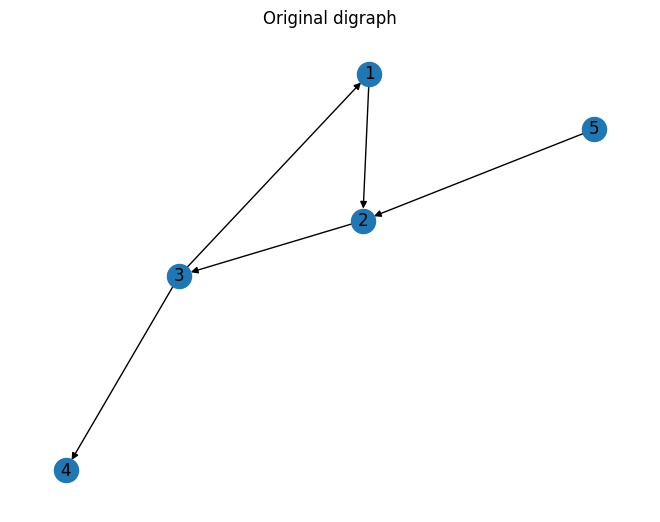

degree_product: |F|=1, time=0.0011s, valid=True


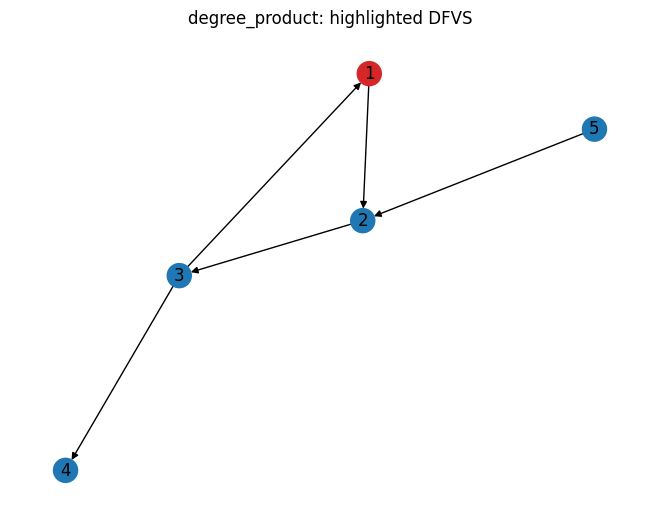

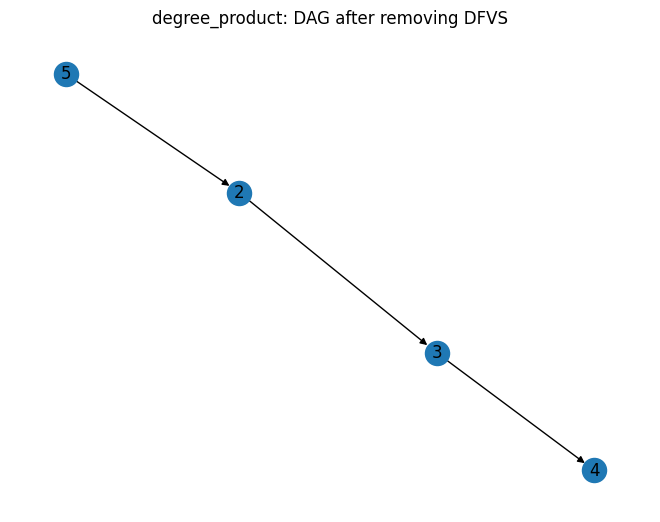

frequency: |F|=1, time=0.0018s, valid=True


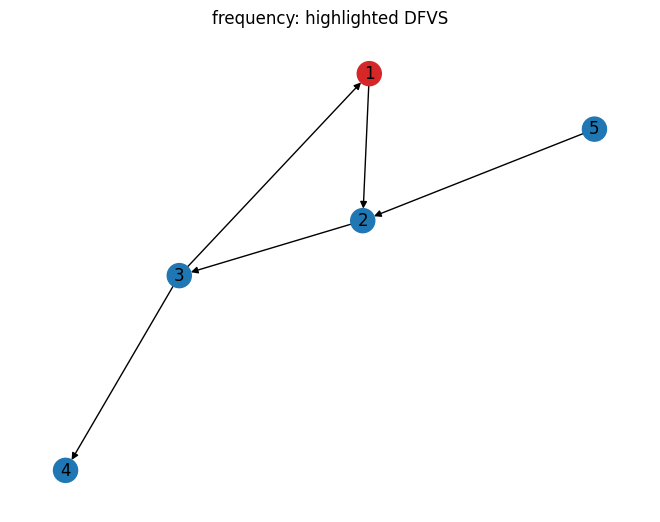

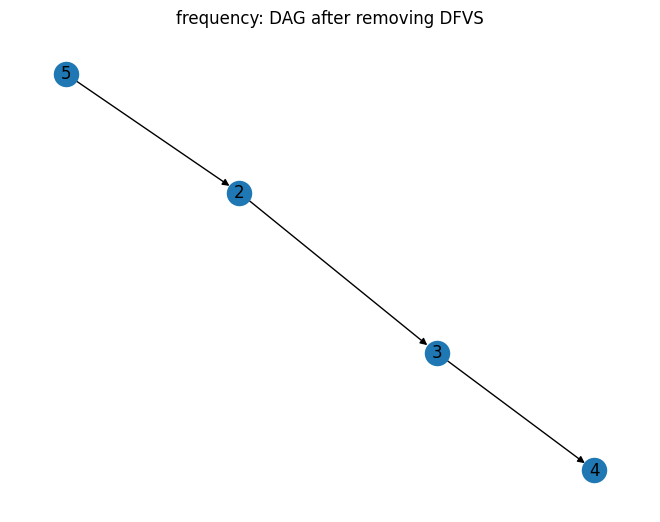

naive_small: |F|=1, time=0.0002s, valid=True


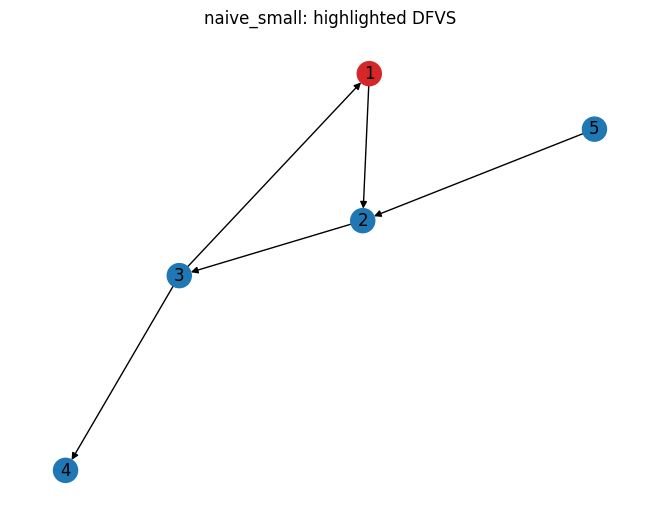

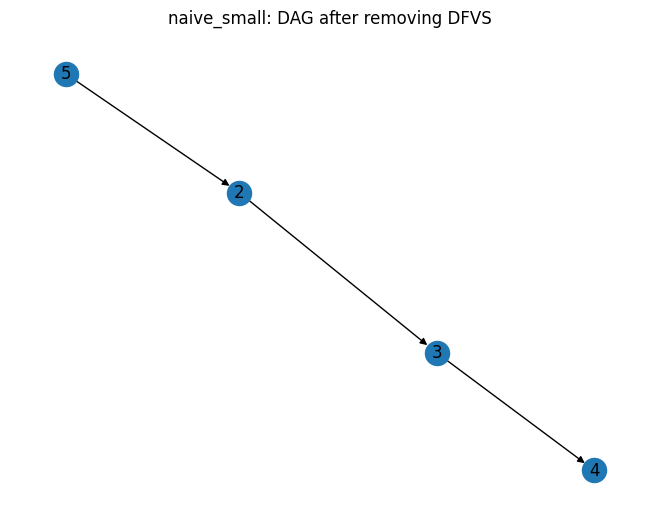

d_sequence: |F|=1, time=0.0007s, valid=True


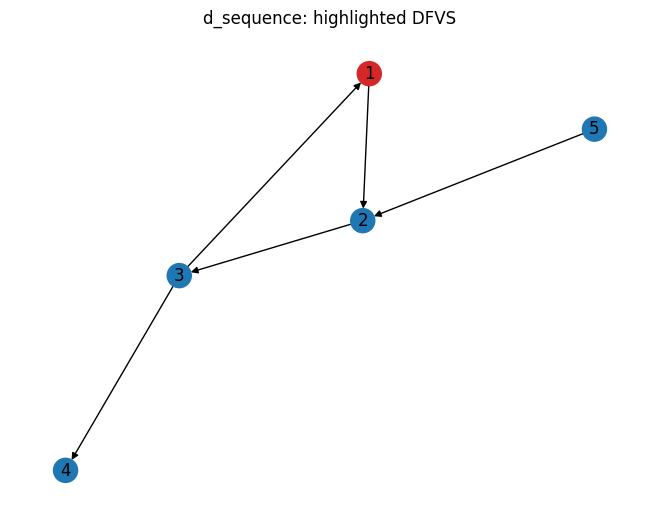

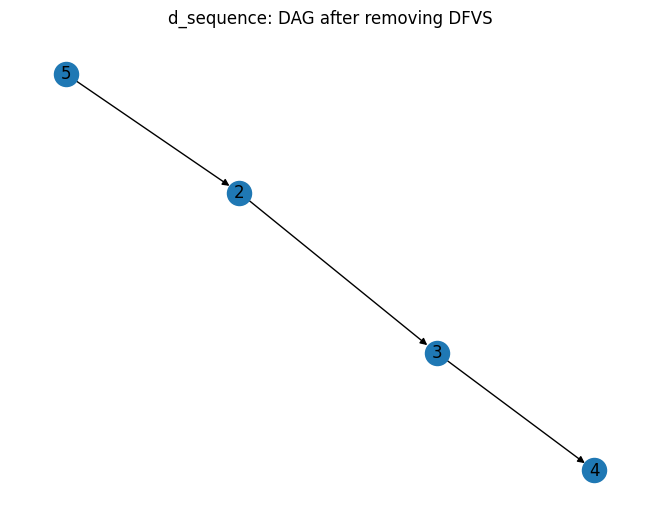

D-sequence order: [1]
IC_dfvs_small_k: |F|=1, time=0.0010s, valid=True


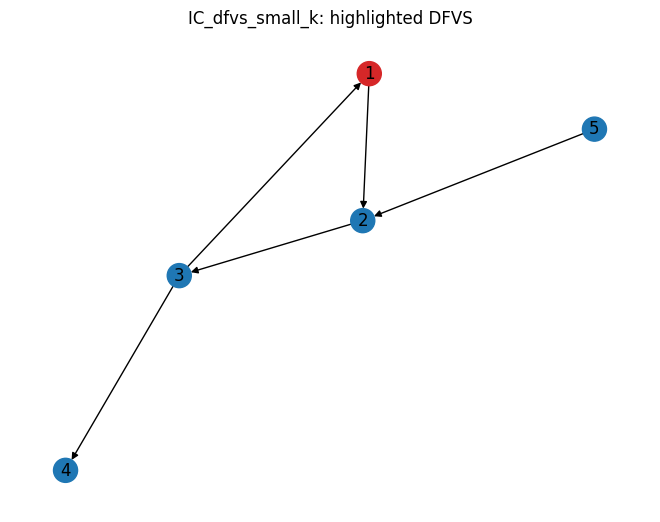

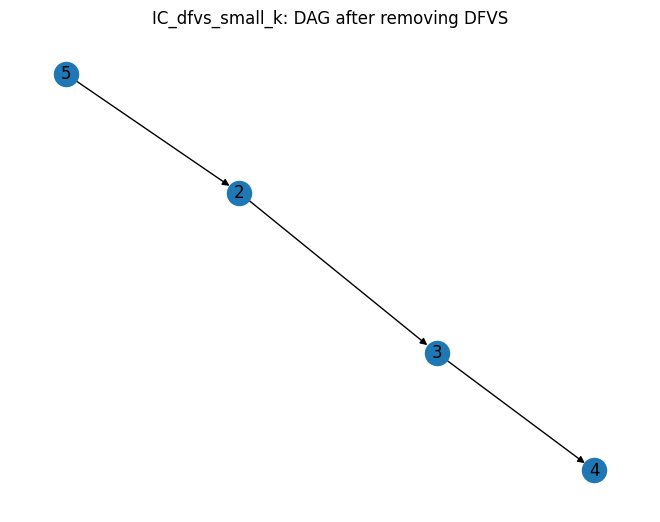

In [9]:
# Demo instance
G_demo = nx.DiGraph(); G_demo.add_edges_from([(1,2),(2,3),(3,1),(3,4),(5,2)])
draw_digraph(G_demo, 'Original digraph')

# Show each heuristic directly below its section:
run_degprod_and_plot(G_demo, time_limit=2.0)
run_frequency_and_plot(G_demo, cap=200)
run_naive_and_plot(G_demo, time_limit=2.0)
run_dseq_and_plot(G_demo)
run_ic_small_and_plot(G_demo, k = 20)

## Random Directed Graph Generation and Heuristic Analysis

Instance: Graph_15_nodes_p0.15


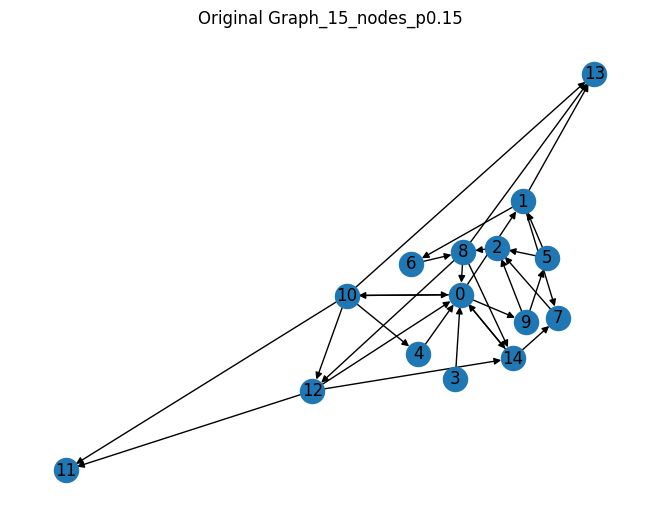

degree_product: |F|=2, time=0.0004s, valid=True


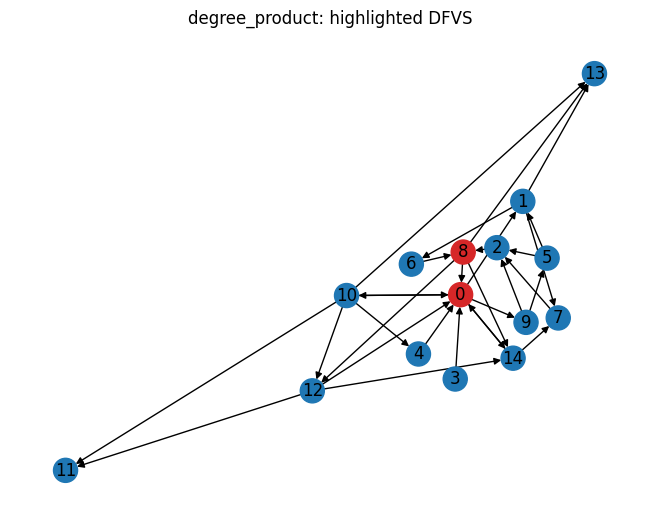

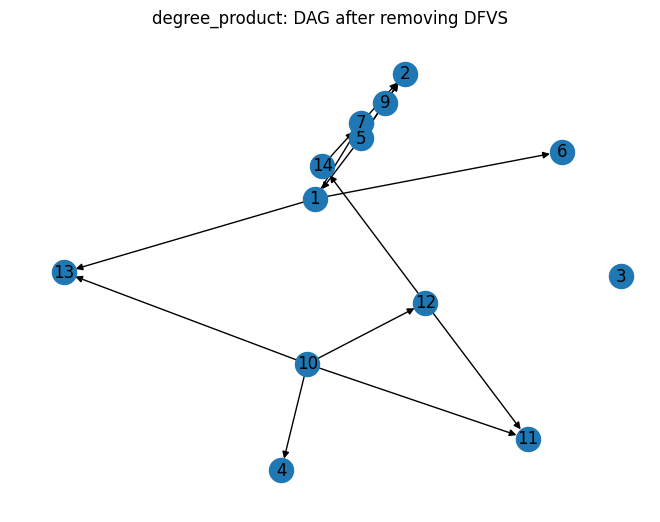

frequency: |F|=2, time=0.0017s, valid=True


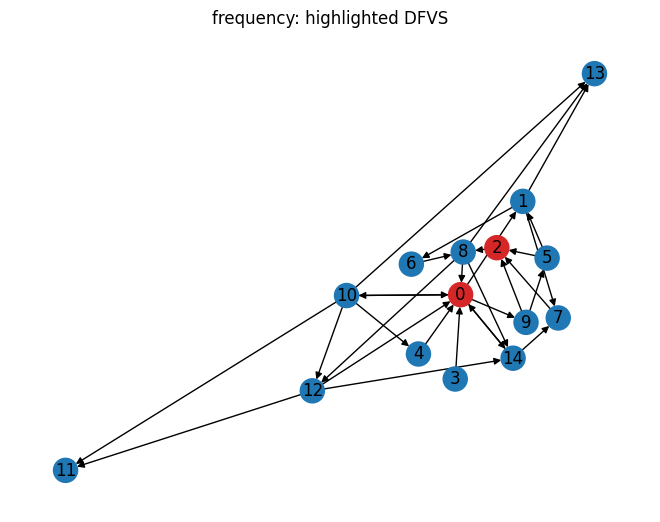

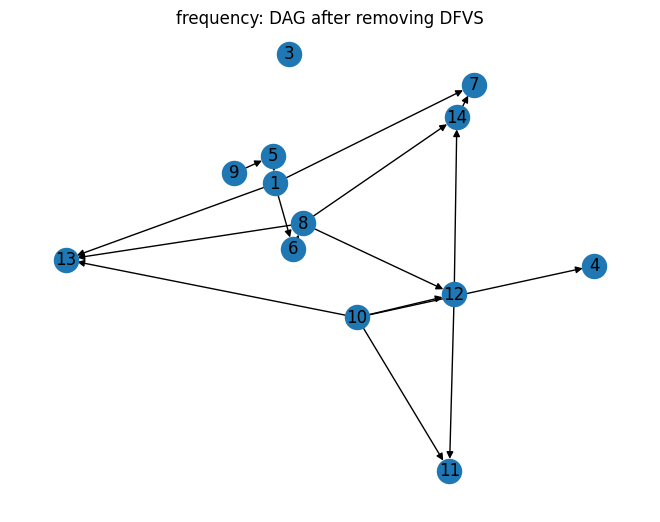

Naive exact skipped: graph too large
d_sequence: |F|=0, time=0.0196s, valid=False


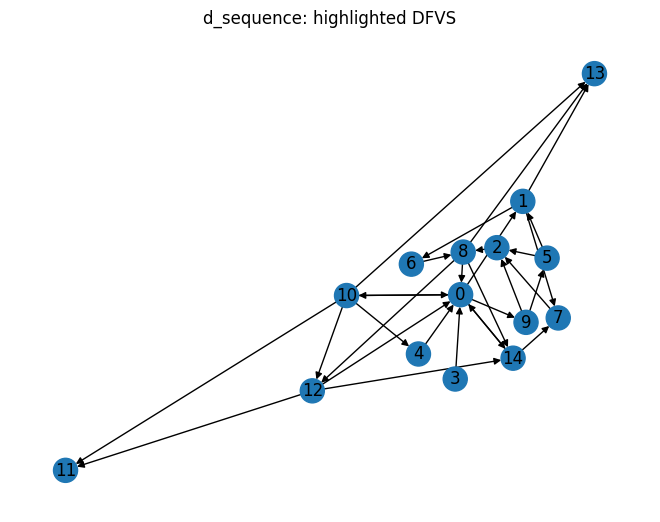

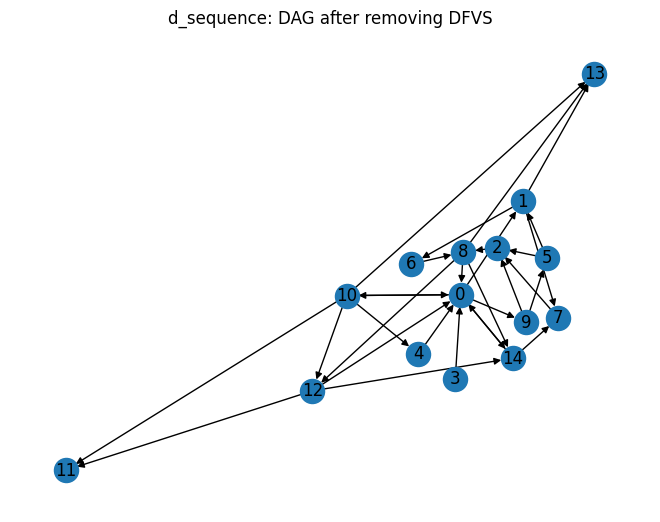

D-sequence order: []
IC_dfvs_small_k: |F|=3, time=0.0143s, valid=True


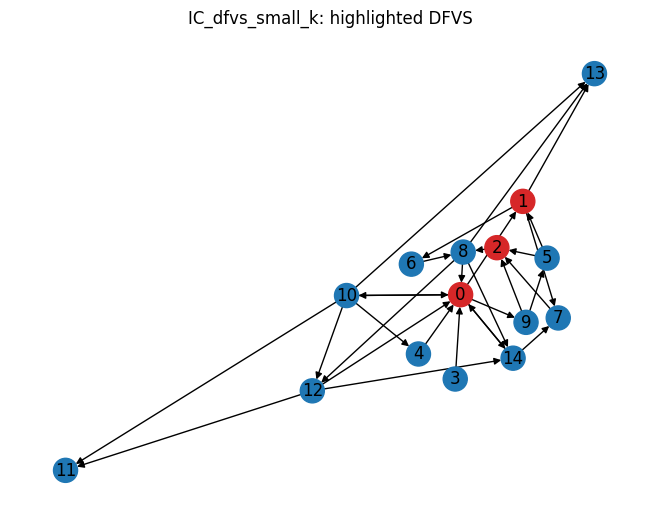

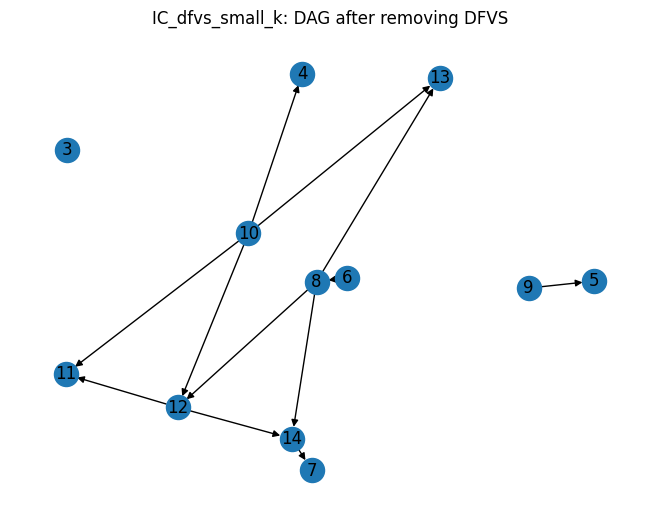

Instance: Graph_20_nodes_p0.10


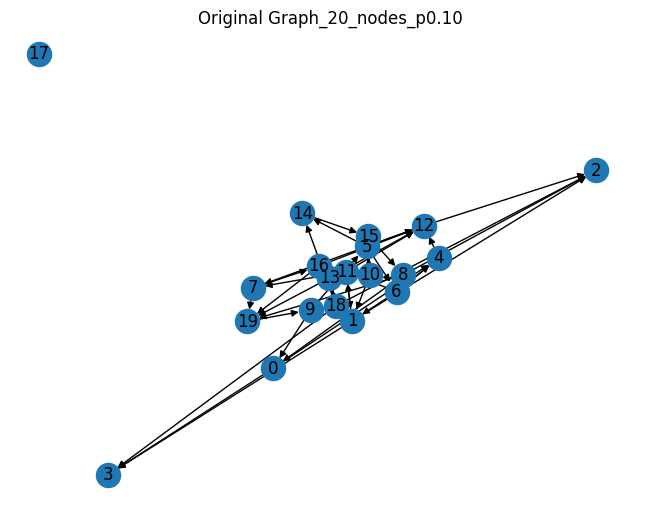

degree_product: |F|=5, time=0.0011s, valid=True


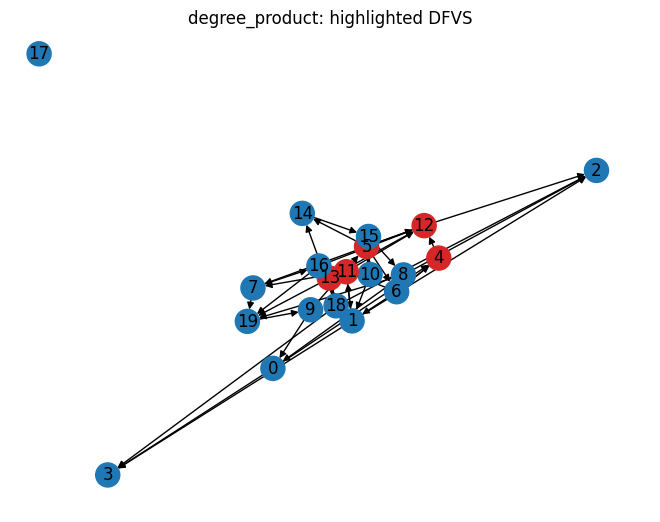

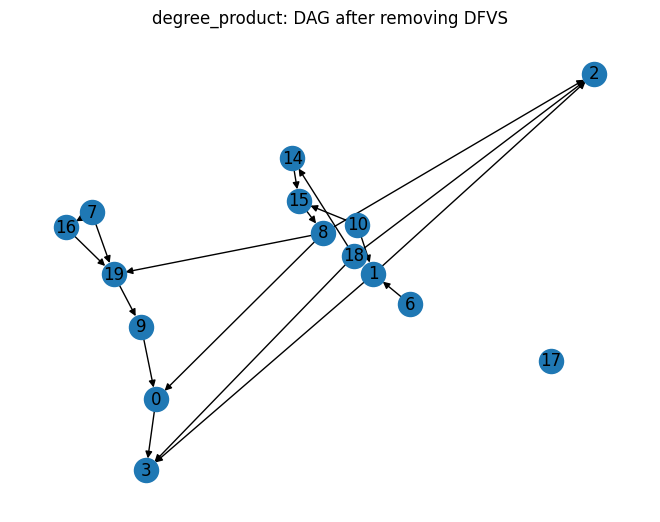

frequency: |F|=6, time=0.0069s, valid=True


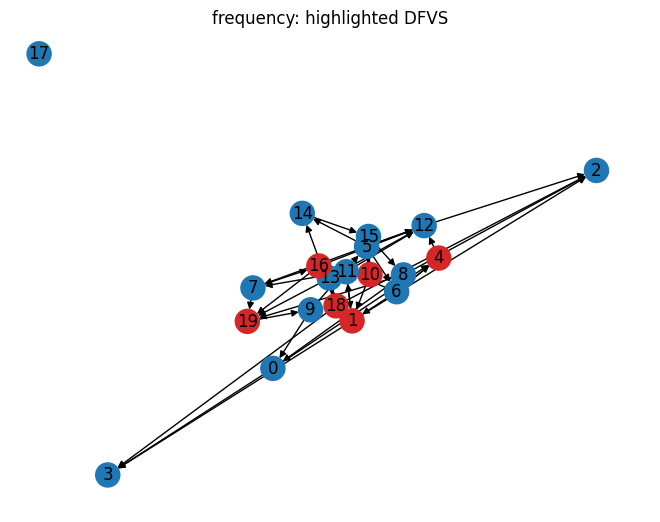

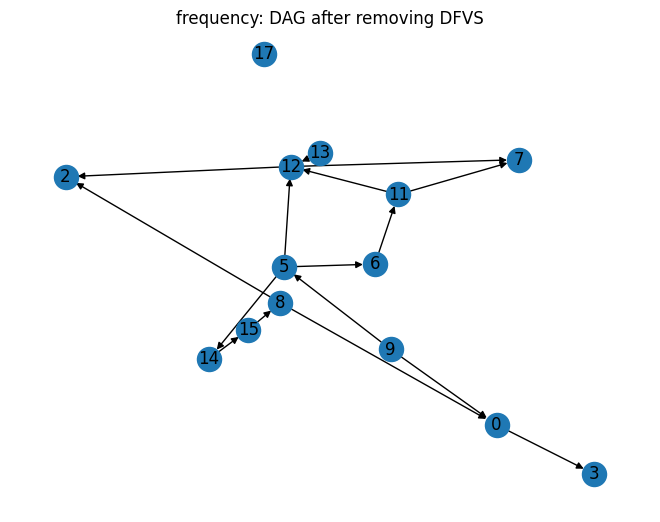

Naive exact skipped: graph too large
d_sequence: |F|=5, time=0.0350s, valid=True


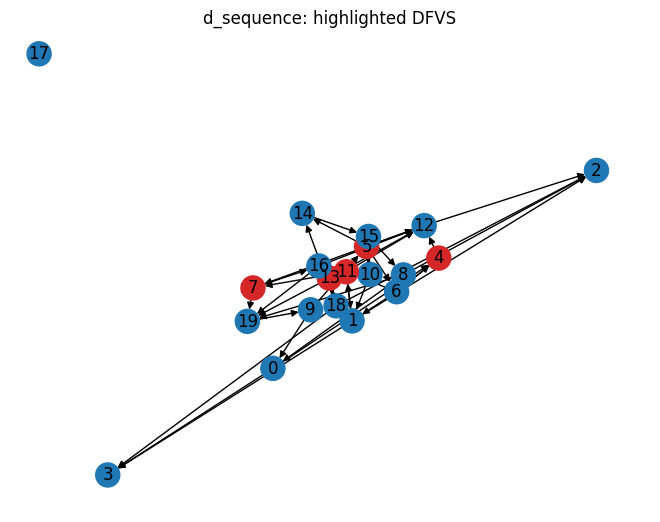

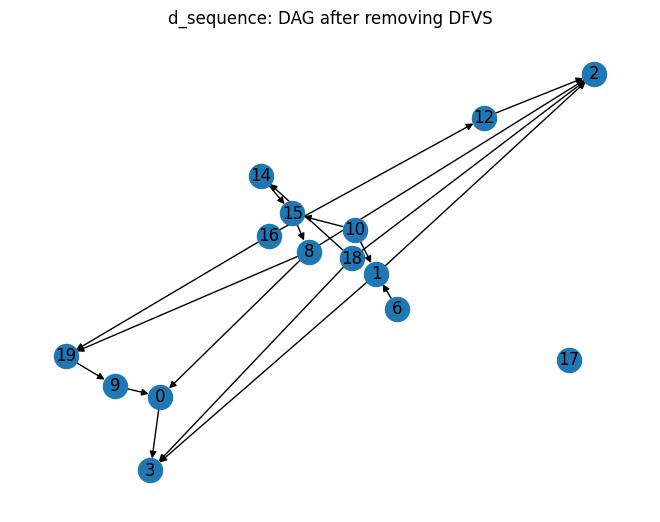

D-sequence order: [11, 4, 5, 7, 13]
IC_dfvs_small_k: |F|=6, time=0.0084s, valid=True


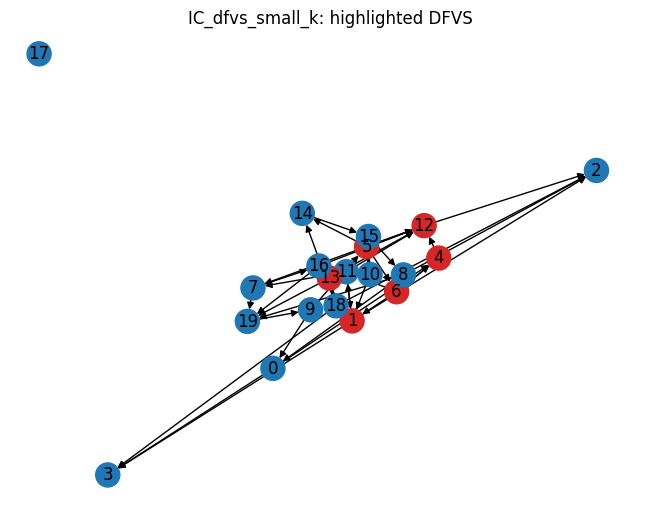

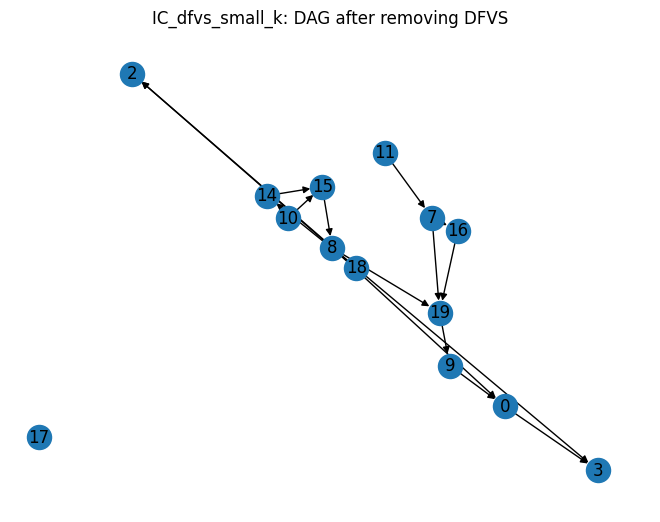

Instance: Graph_30_nodes_p0.08


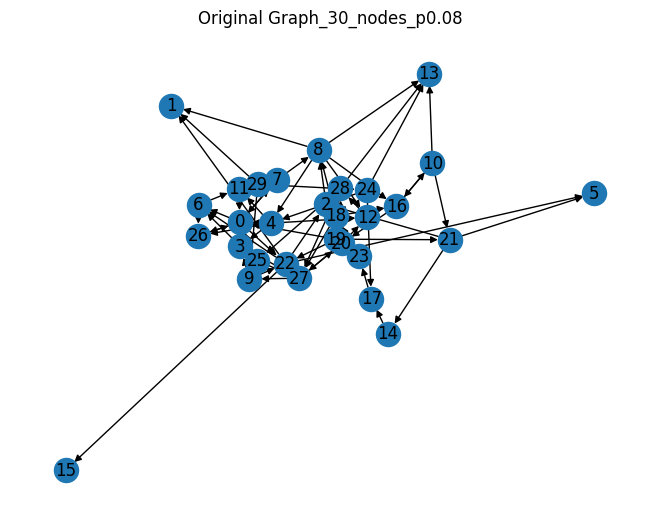

degree_product: |F|=6, time=0.0013s, valid=True


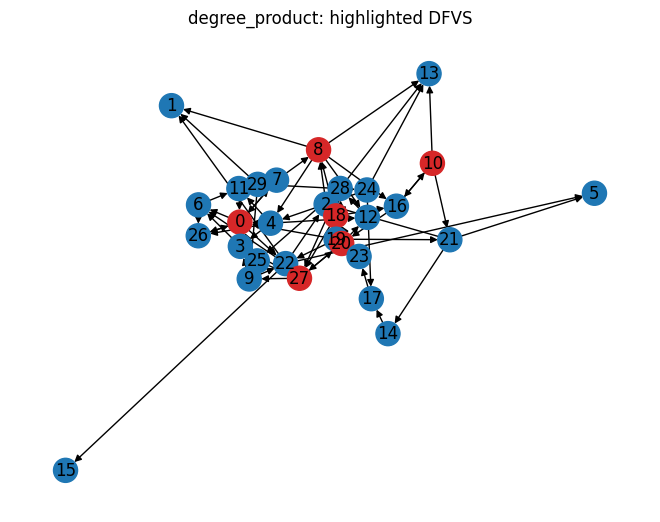

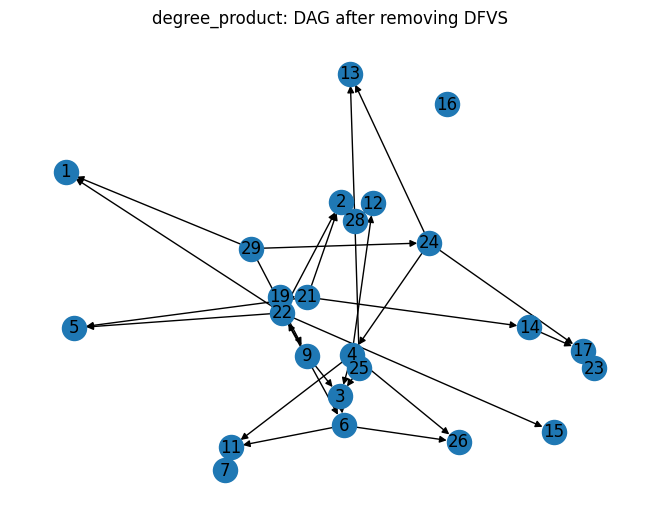

frequency: |F|=6, time=0.0261s, valid=True


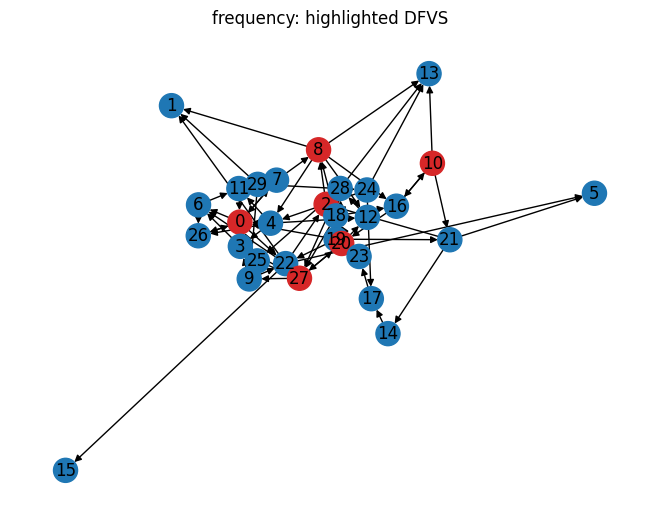

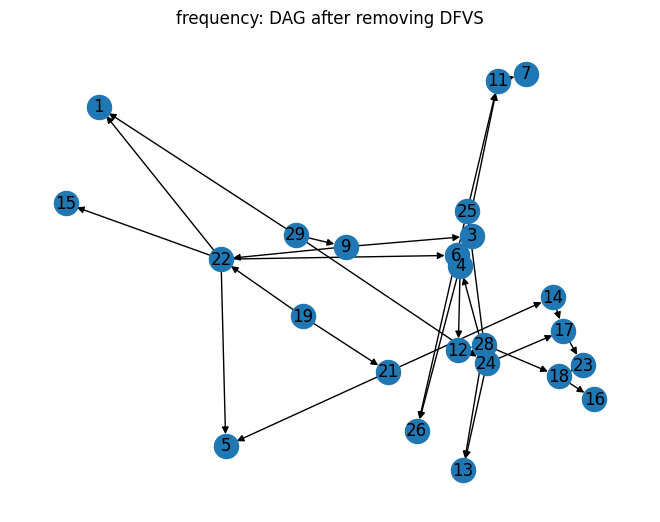

Naive exact skipped: graph too large
d_sequence: |F|=1, time=0.2349s, valid=False


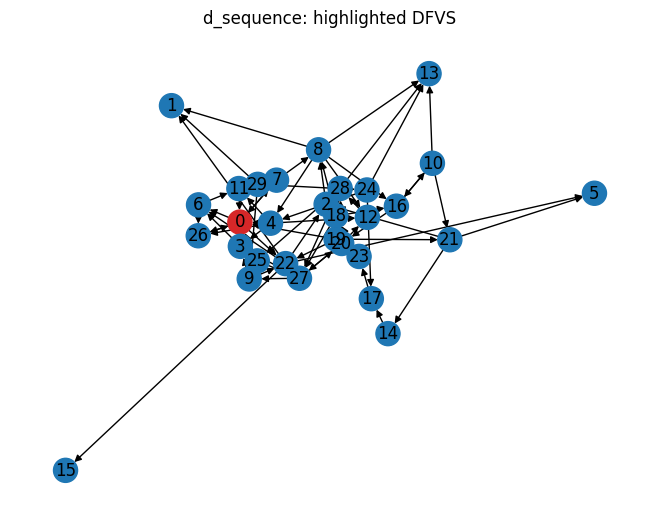

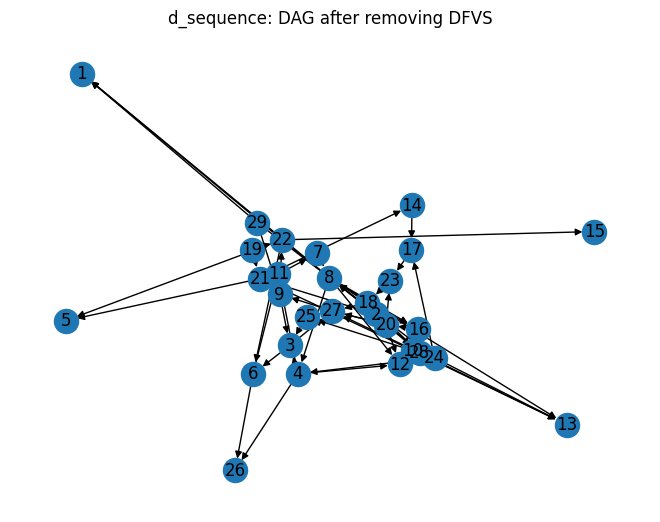

D-sequence order: [0]
IC_dfvs_small_k: |F|=6, time=0.0777s, valid=True


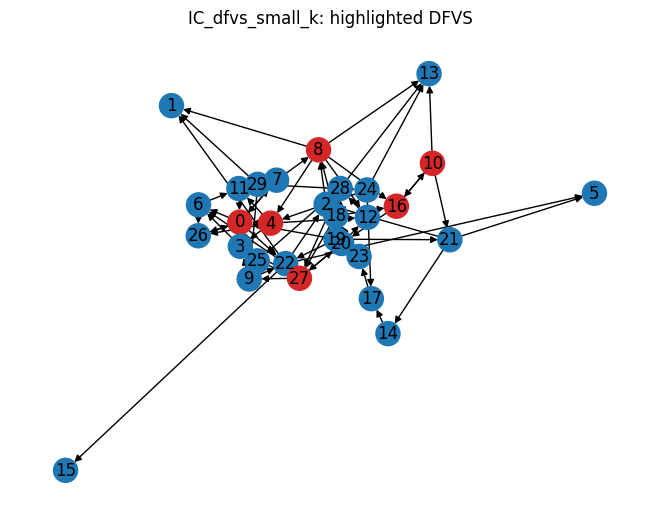

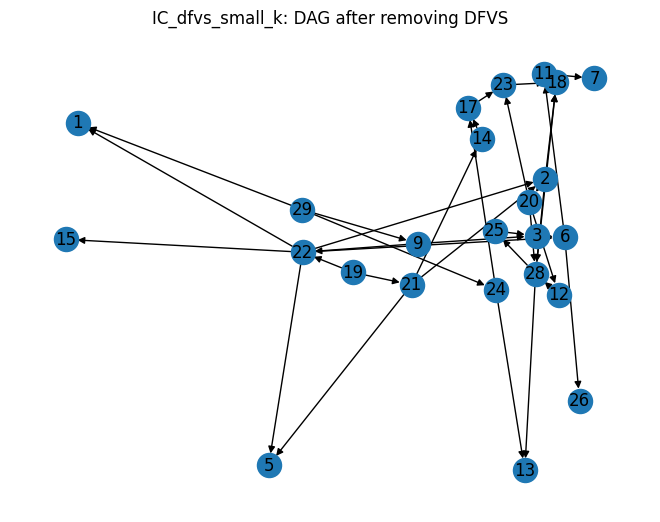

In [10]:
def random_digraph(n: int, p: float, seed: int = 0) -> nx.DiGraph:
    import random
    rnd = random.Random(seed)
    G = nx.DiGraph(); G.add_nodes_from(range(n))
    for u in range(n):
        for v in range(n):
            if u != v and rnd.random() < p:
                G.add_edge(u, v)
    return G

# Test instances: larger, denser digraphs
instances = [
    ("Graph_15_nodes_p0.15", random_digraph(15, 0.15, seed=1)),
    ("Graph_20_nodes_p0.10", random_digraph(20, 0.10, seed=2)),
    ("Graph_30_nodes_p0.08", random_digraph(30, 0.08, seed=3)),
]

for name, G in instances:
    print("="*60)
    print("Instance:", name)
    draw_digraph(G, f"Original {name}")
    
    # Degree-product heuristic
    run_degprod_and_plot(G, time_limit=3.0)
    
    # Frequency heuristic
    run_frequency_and_plot(G, cap=2000)
    
    # Naive exact (only feasible for very small n, so skip if too big)
    if G.number_of_nodes() <= 12:
        run_naive_and_plot(G, time_limit=3.0)
    else:
        print("Naive exact skipped: graph too large")
    
    # D-sequence heuristic
    run_dseq_and_plot(G)

    #IC Small-k heuristic
    run_ic_small_and_plot(G, k = 20)

In [11]:
# Loading graphs from literature
G1 = load_digraph_from_edgelist('./data/G1_edgelist.csv')
G2 = load_digraph_from_edgelist('./data/G2_edgelist.csv')
G3 = load_digraph_from_edgelist('./data/G3_edgelist.csv')
G4 = load_digraph_from_edgelist('./data/G4_edgelist.csv')

TESTING ALGORITHMS ON G1
degree_product: |F|=5, time=0.0030s, valid=True


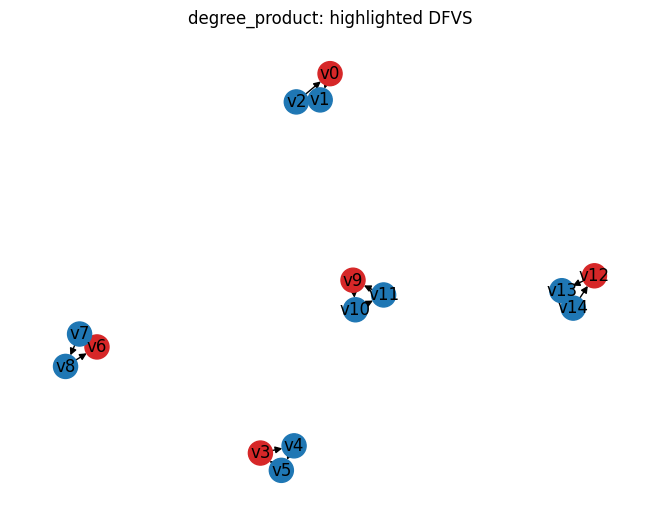

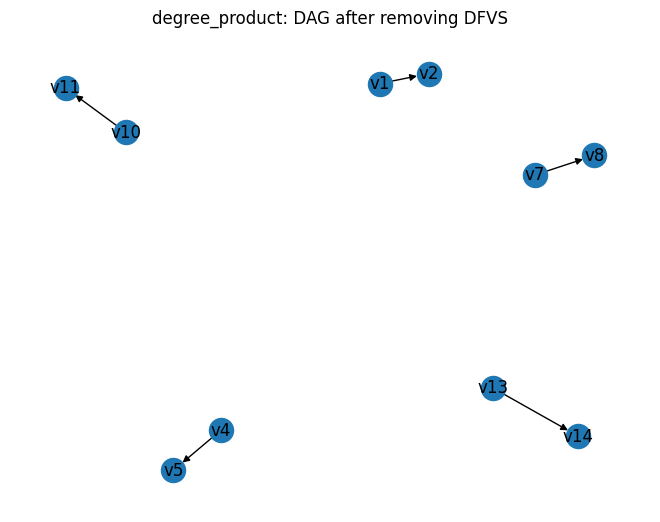

frequency: |F|=5, time=0.0029s, valid=True


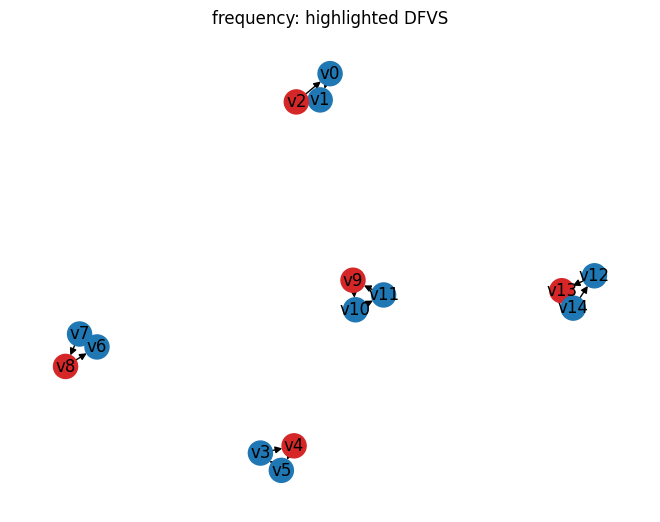

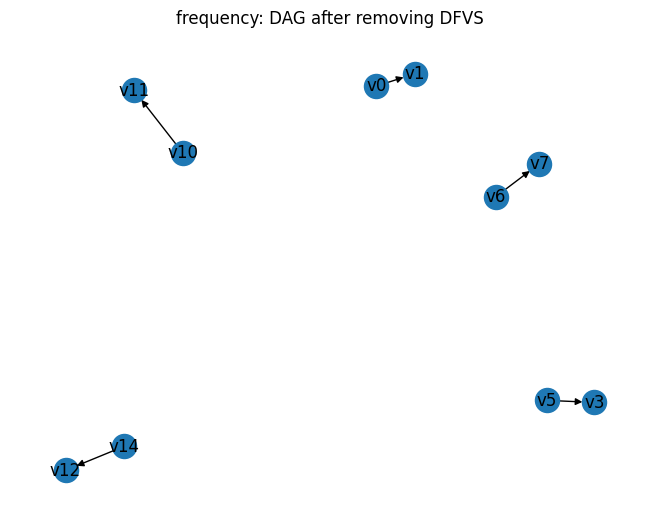

naive_small: |F|=5, time=0.3885s, valid=True


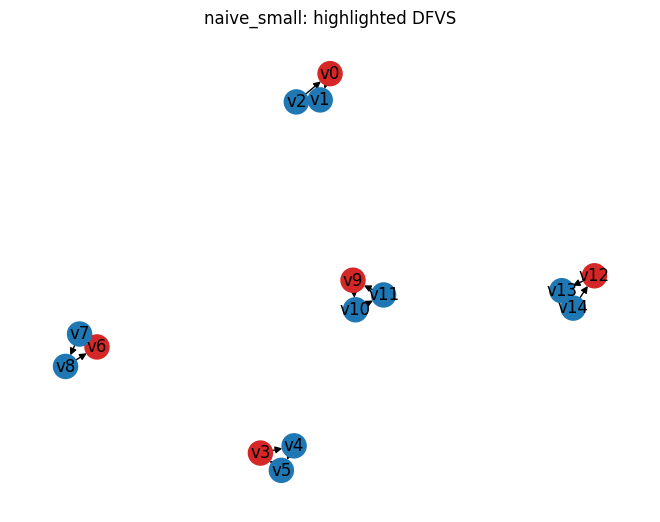

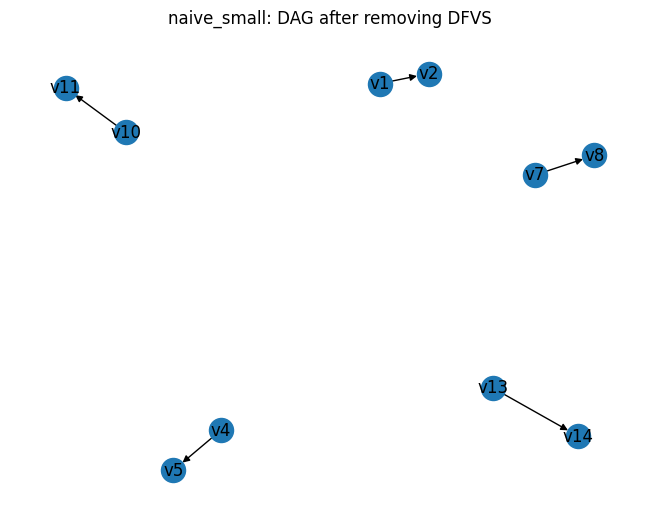

d_sequence: |F|=5, time=0.0052s, valid=True


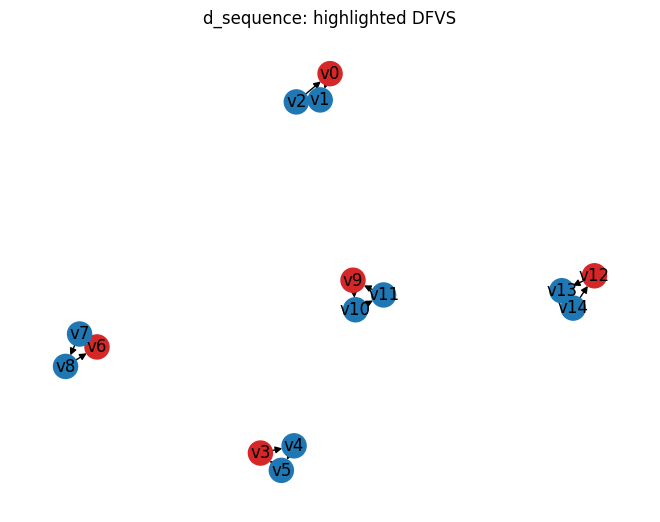

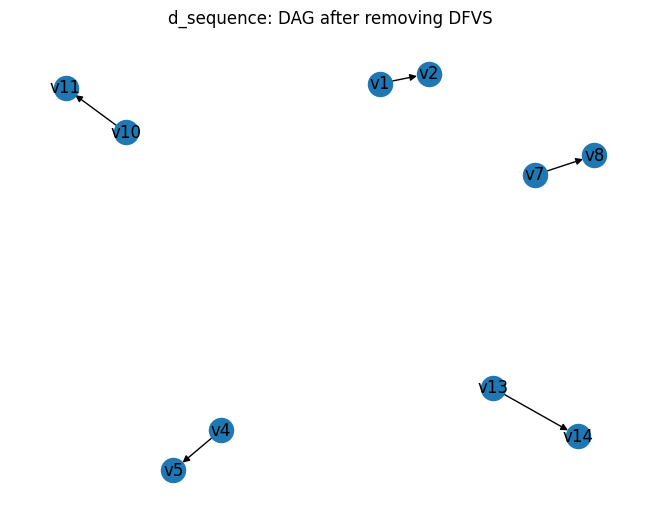

D-sequence order: ['v0', 'v3', 'v6', 'v9', 'v12']
IC_dfvs_small_k: |F|=5, time=0.0058s, valid=True


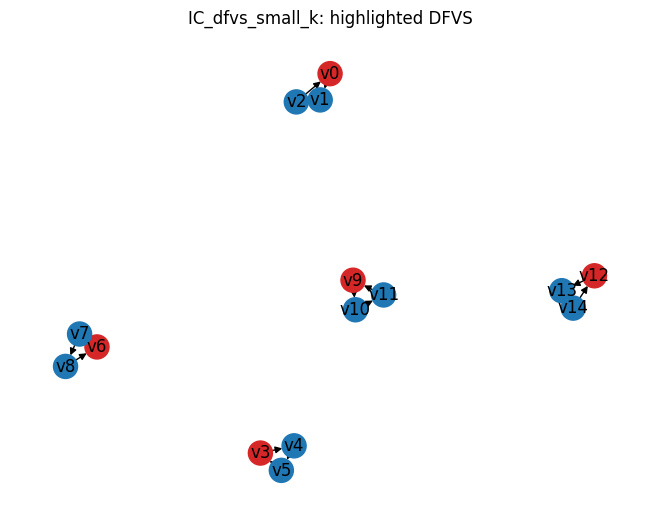

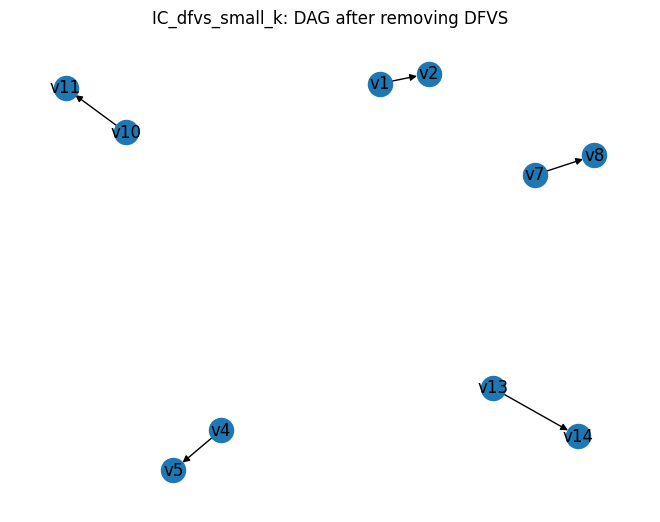

In [12]:
print("TESTING ALGORITHMS ON G1")
run_degprod_and_plot(G1, time_limit=2.0)
run_frequency_and_plot(G1, cap=200)
run_naive_and_plot(G1, time_limit=2.0)
run_dseq_and_plot(G1)
run_ic_small_and_plot(G1, k = 20)

TESTING ALGORITHMS ON G2
degree_product: |F|=10, time=0.0085s, valid=True


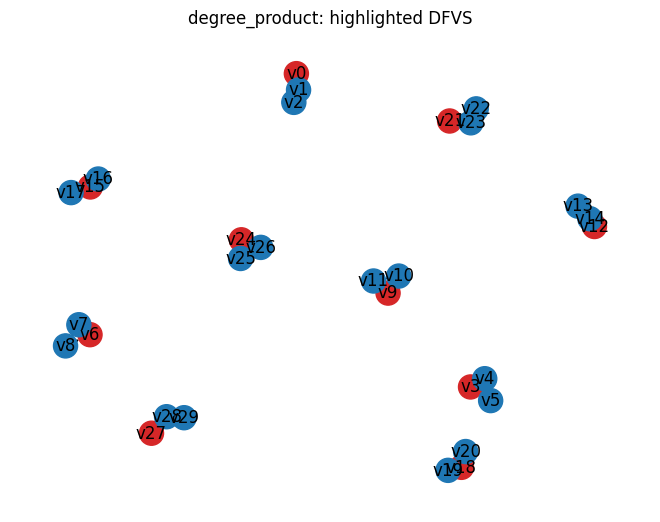

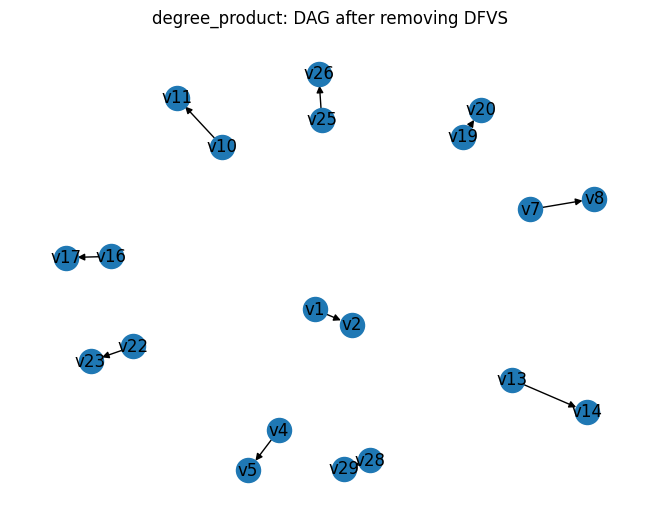

frequency: |F|=10, time=0.0094s, valid=True


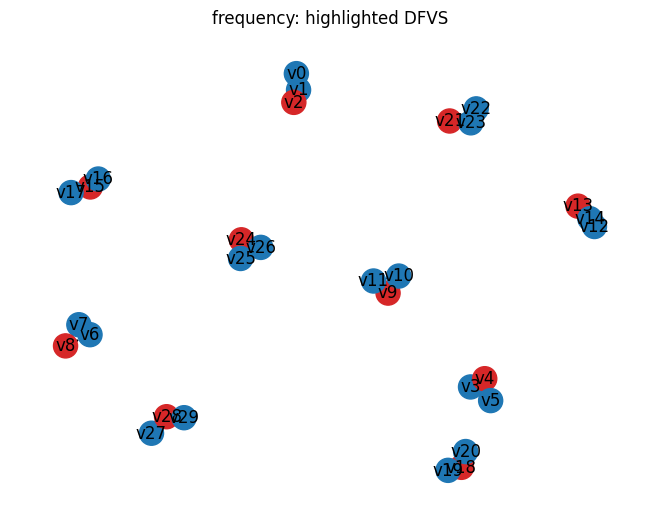

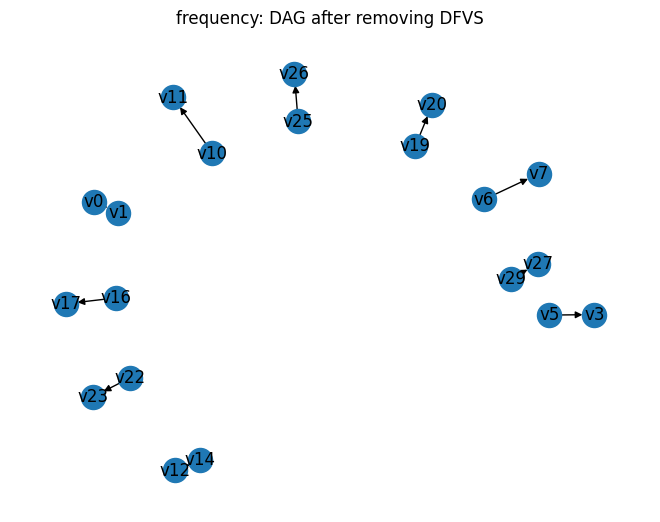

naive_small: |F|=30, time=2.0000s, valid=True


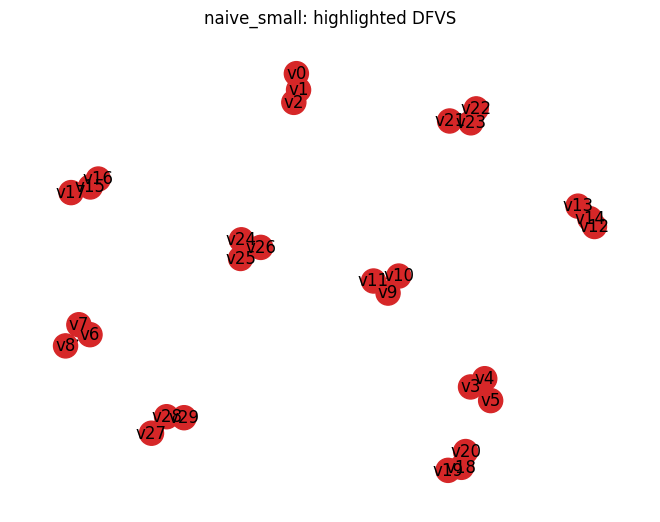

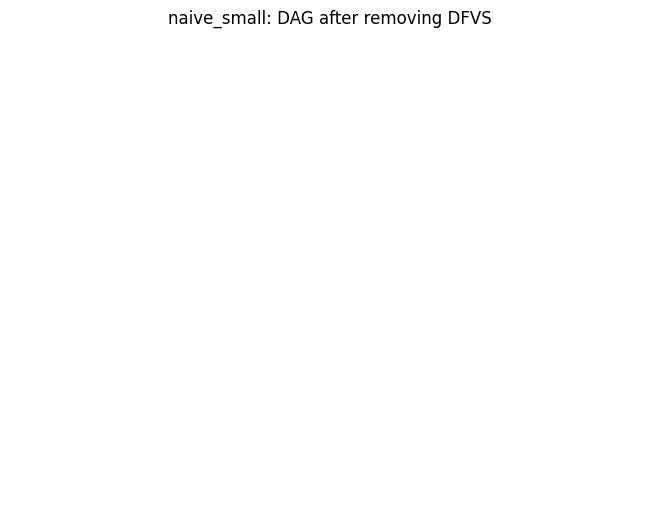

d_sequence: |F|=10, time=0.0181s, valid=True


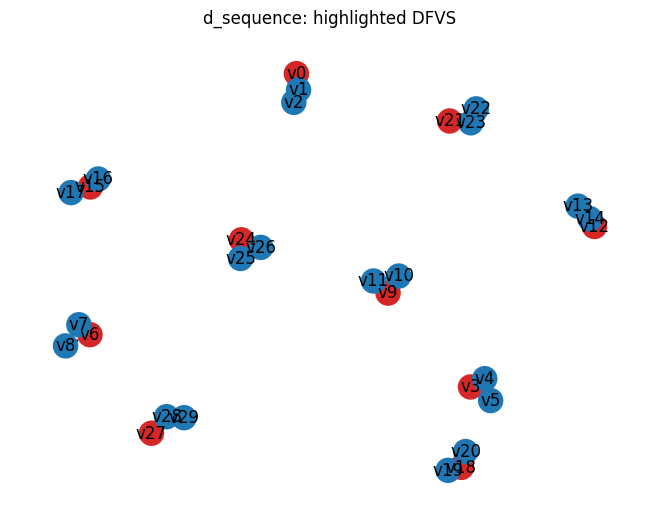

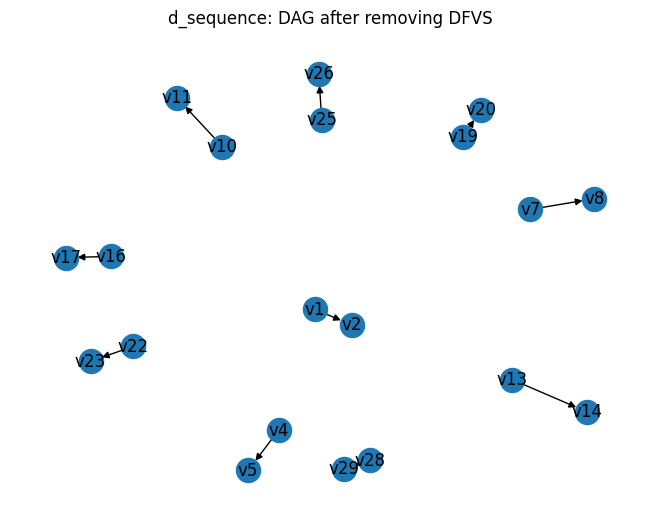

D-sequence order: ['v0', 'v3', 'v6', 'v9', 'v12', 'v15', 'v18', 'v21', 'v24', 'v27']
IC_dfvs_small_k: |F|=10, time=0.0351s, valid=True


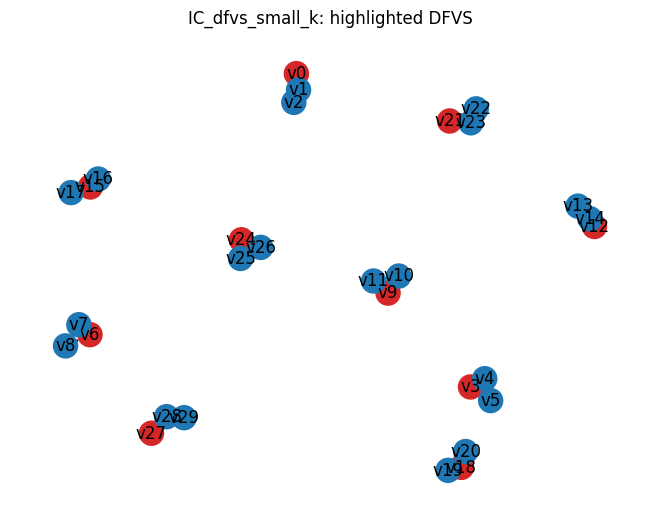

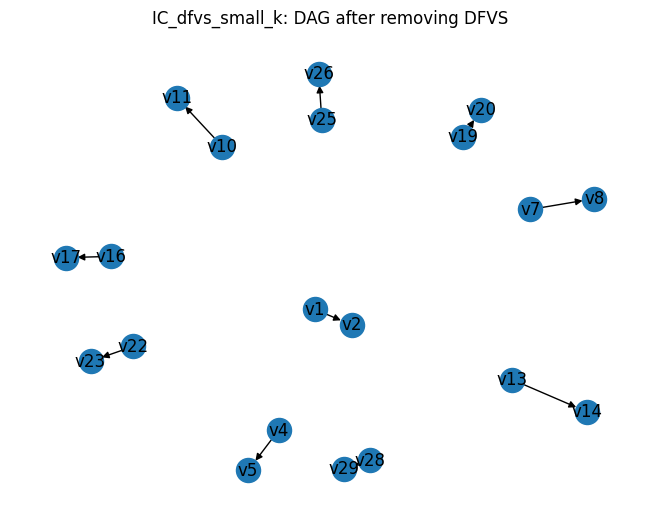

In [13]:
print("TESTING ALGORITHMS ON G2")
run_degprod_and_plot(G2, time_limit=2.0)
run_frequency_and_plot(G2, cap=200)
run_naive_and_plot(G2, time_limit=2.0)
run_dseq_and_plot(G2)
run_ic_small_and_plot(G2, k = 20)

TESTING ALGORITHMS ON G3
degree_product: |F|=24, time=0.0406s, valid=True


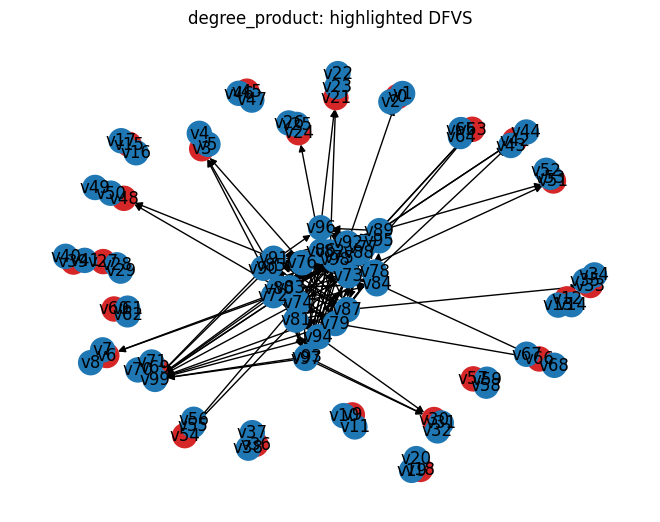

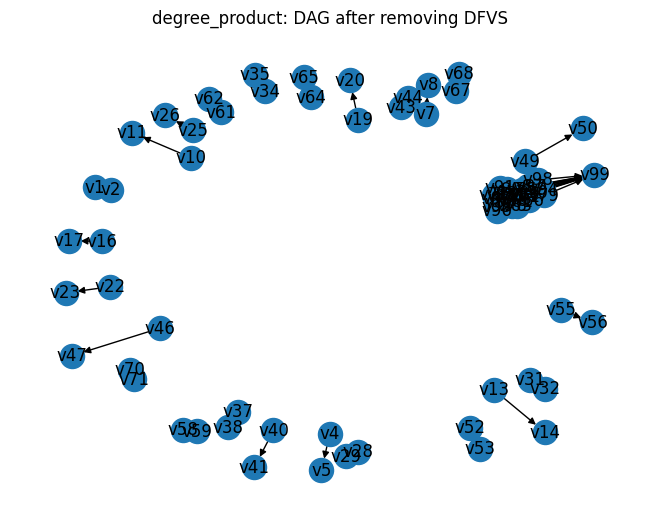

frequency: |F|=24, time=0.0545s, valid=True


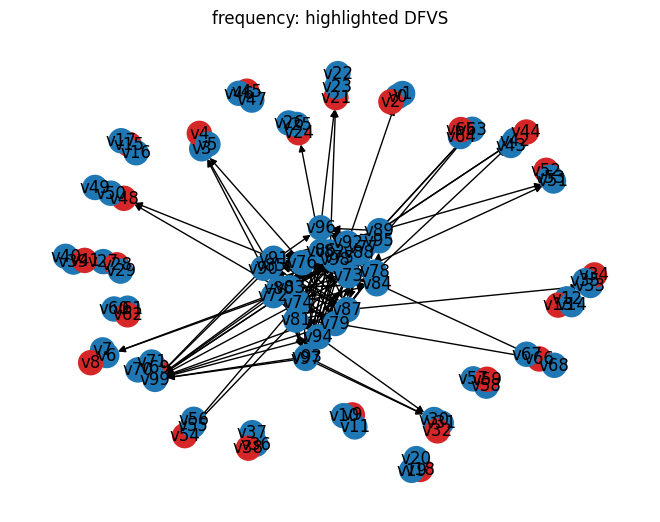

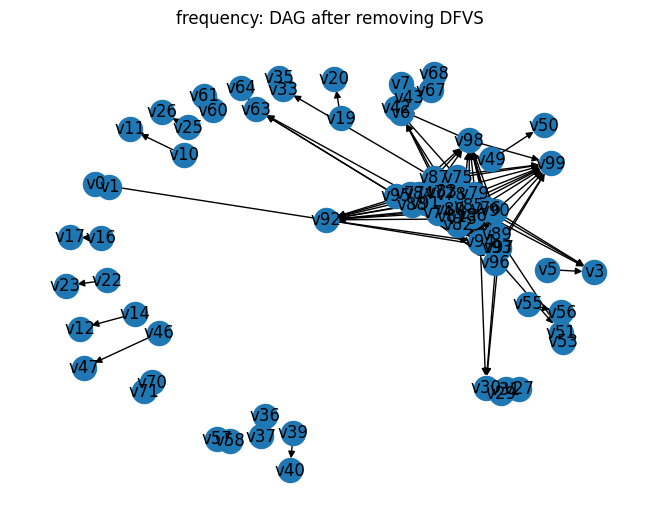

naive_small: |F|=100, time=2.0007s, valid=True


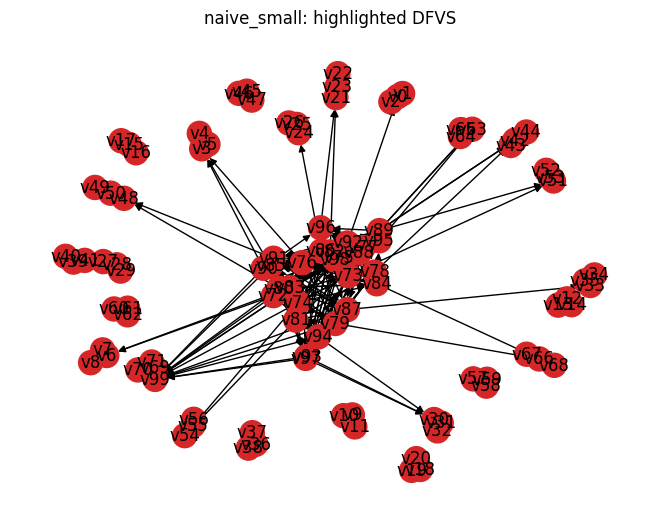

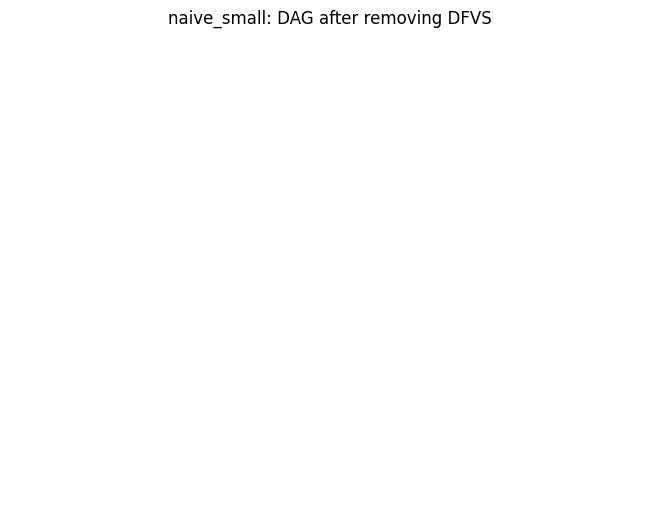

d_sequence: |F|=24, time=0.2649s, valid=True


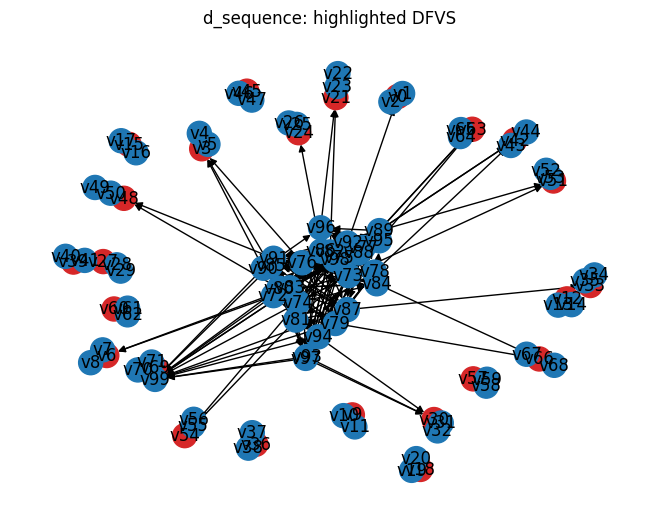

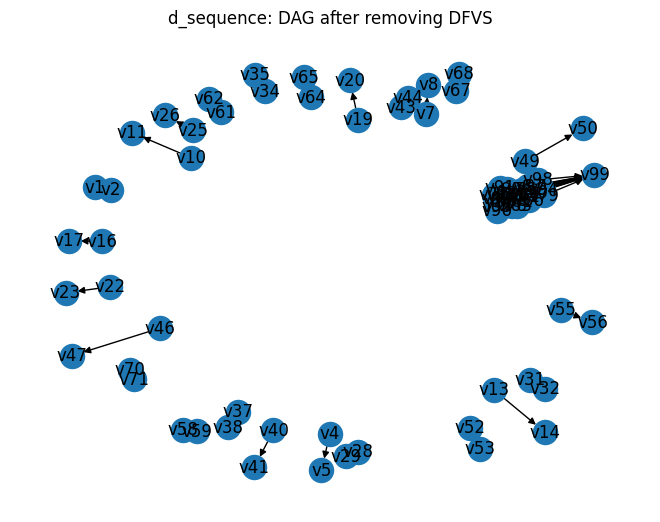

D-sequence order: ['v0', 'v3', 'v6', 'v9', 'v12', 'v15', 'v18', 'v21', 'v24', 'v27', 'v30', 'v33', 'v36', 'v39', 'v42', 'v45', 'v48', 'v51', 'v54', 'v57', 'v60', 'v63', 'v66', 'v69']


In [ ]:
print("TESTING ALGORITHMS ON G3")
run_degprod_and_plot(G3, time_limit=2.0)
run_frequency_and_plot(G3, cap=200)
run_naive_and_plot(G3, time_limit=2.0)
run_dseq_and_plot(G3)
run_ic_small_and_plot(G3, k = 20)

In [ ]:
print("TESTING ALGORITHMS ON G4")
run_degprod_and_plot(G4, time_limit=2.0)
run_frequency_and_plot(G4, cap=200)
run_naive_and_plot(G4, time_limit=2.0)
run_dseq_and_plot(G4)
run_ic_small_and_plot(G4, k = 20)